In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from xgboost import XGBClassifier
import xgboost as xgb
import os
import sys

# TODO: handle this by running setup.py ?
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from src.drift.drift_explainer import DriftExplainer

# config
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

seed = 2021

# IEEE fraud data

if you have setup a kaggle api token

In [3]:
#!kaggle competitions download -c ieee-fraud-detection

Else you can download the data here: https://www.kaggle.com/c/ieee-fraud-detection/data, and (I think) you will have to accept the competition rules

In [4]:
df = pd.read_csv('data/train_transaction.csv')

In [5]:
print(df.shape)

(590540, 394)


# Preprocessing

In [6]:
missing_values = df.isnull().sum(axis=0)
missing_values

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D6                517353
D7                551623
D8                515614
D9                515614


In [7]:
selected_columns = [col for col in df.columns if missing_values[col] < 10000]

In [8]:
df = df[selected_columns].dropna(axis=0, how='any')
df = df.loc[df['card6'].isin(['debit', 'credit']), :].copy()

In [9]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0,1758.0,925.0,0.0,354.0,135.0,50.0,1404.0,790.0,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,debit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
is_sorted = lambda x: (np.diff(x)>=0).all()

In [11]:
is_sorted(df['TransactionDT'])

True

# Sampling

In [12]:
features = [col for col in df.columns if col not in ['TransactionID', 'isFraud', 'TransactionDT',
                                                     'ProductCD', 'card4', 'card6']]

In [13]:
df_temp, df_prod = train_test_split(df.copy(), test_size=0.25, shuffle=False)

In [14]:
df_temp['card6'].value_counts()

debit     322580
credit    110956
Name: card6, dtype: int64

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(df_temp.loc[df_temp['card6'].values == 'credit', features].copy(),
                                                      df_temp.loc[df_temp['card6'].values == 'credit', 'isFraud'].values,
                                                      test_size=1/3,
                                                      shuffle=False,
                                                      random_state=seed)

In [16]:
X_prod, y_prod = df_prod[features], df_prod['isFraud'].values

# Build model

In [17]:
clf = XGBClassifier(n_estimators=1000,
                    booster="gbtree",
                    objective="binary:logistic",
                    learning_rate=0.1,
                    max_depth=6,
                    use_label_encoder=False,
                    seed=seed)

In [18]:
clf.fit(X=X_train, y=y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=20,
        verbose=10, eval_metric=['auc', 'logloss'])

[0]	validation_0-auc:0.80711	validation_0-logloss:0.61543
[10]	validation_0-auc:0.85454	validation_0-logloss:0.28218
[20]	validation_0-auc:0.86206	validation_0-logloss:0.20367
[30]	validation_0-auc:0.87123	validation_0-logloss:0.18422
[40]	validation_0-auc:0.87968	validation_0-logloss:0.17869
[50]	validation_0-auc:0.88851	validation_0-logloss:0.17534
[60]	validation_0-auc:0.89127	validation_0-logloss:0.17464
[70]	validation_0-auc:0.89233	validation_0-logloss:0.17446
[80]	validation_0-auc:0.89309	validation_0-logloss:0.17445
[90]	validation_0-auc:0.89482	validation_0-logloss:0.17351
[100]	validation_0-auc:0.89476	validation_0-logloss:0.17361
[110]	validation_0-auc:0.89538	validation_0-logloss:0.17343
[112]	validation_0-auc:0.89535	validation_0-logloss:0.17349


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1,
              random_state=2021, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=2021, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

# Detection of data drift

In [19]:
drift_explainer = DriftExplainer()

In [20]:
drift_explainer.fit(clf, X1=X_valid, X2=X_prod, y1=y_valid, y2=y_prod)

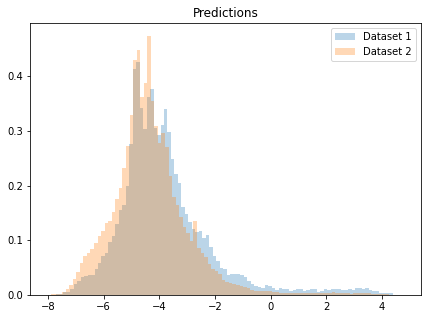

[{'mean_difference': -0.514477079781603,
  'wasserstein': 0.5144829964200954,
  'kolmogorov_smirnov': KstestResult(statistic=0.13030577961608247, pvalue=0.0)}]

In [21]:
drift_explainer.plot_prediction_drift(figsize=(7, 5))
drift_explainer.get_prediction_drift()

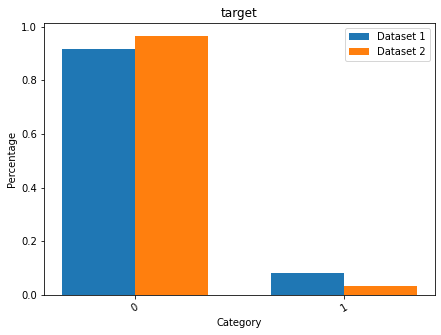

{'wasserstein': 0.04893272477192796,
 'chi2_test': {'chi2_stat': 1655.184463874216,
  'p_value': 0.0,
  'dof': 1,
  'contingency_table':            0       1
  X1   33897.0  3089.0
  X2  139514.0  4998.0}}

In [22]:
drift_explainer.plot_target_drift()
drift_explainer.get_target_drift()

In [23]:
print(f'log_loss valid: {log_loss(y_valid, clf.predict_proba(X_valid))}')
print(f'log_loss prod: {log_loss(y_prod, clf.predict_proba(X_prod))}')

print(f'AUC valid: {roc_auc_score(y_valid, clf.predict_proba(X_valid)[:, 1])}')
print(f'AUC prod: {roc_auc_score(y_prod, clf.predict_proba(X_prod)[:, 1])}')

log_loss valid: 0.17342663278191264
log_loss prod: 0.10822475472437297
AUC valid: 0.8950968405582416
AUC prod: 0.8393885465363519


# Explain data drift

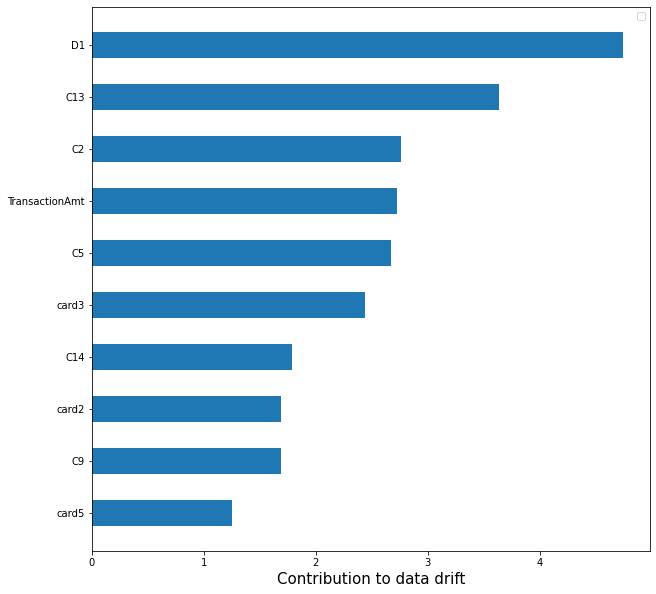

In [24]:
drift_explainer.plot_feature_contribs(type='node_size')

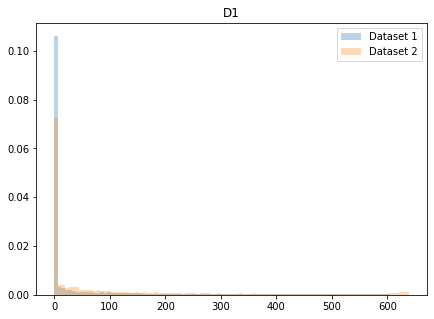

{'mean_difference': 46.8838287777281,
 'wasserstein': 46.8838287777281,
 'kolmogorov_smirnov': KstestResult(statistic=0.21429019063158317, pvalue=0.0)}

In [25]:
drift_explainer.plot_feature_drift('D1')
drift_explainer.get_feature_drift('D1')

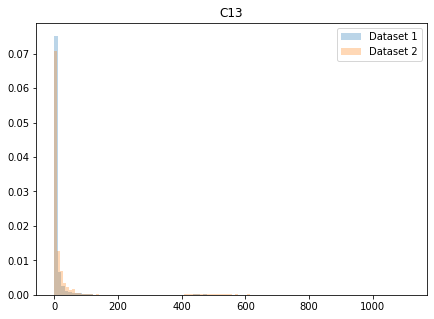

{'mean_difference': 17.01094623883851,
 'wasserstein': 17.031872502765626,
 'kolmogorov_smirnov': KstestResult(statistic=0.20382416844747753, pvalue=0.0)}

In [26]:
drift_explainer.plot_feature_drift('C13')
drift_explainer.get_feature_drift('C13')

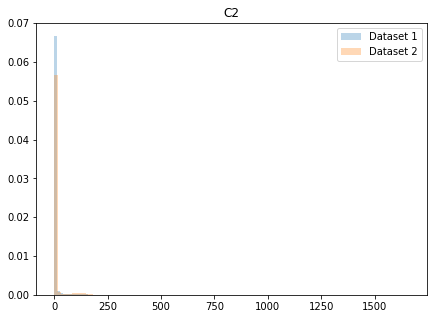

{'mean_difference': 1.2646117311097331,
 'wasserstein': 2.9889224443428146,
 'kolmogorov_smirnov': KstestResult(statistic=0.10176789237801753, pvalue=5.565022422639659e-266)}

In [27]:
drift_explainer.plot_feature_drift('C2')
drift_explainer.get_feature_drift('C2')

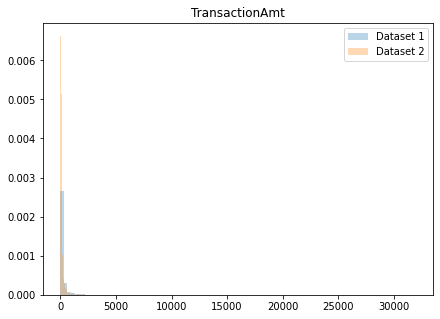

{'mean_difference': -63.08057386681716,
 'wasserstein': 63.79154259538975,
 'kolmogorov_smirnov': KstestResult(statistic=0.1276862396004147, pvalue=0.0)}

In [28]:
drift_explainer.plot_feature_drift('TransactionAmt')
drift_explainer.get_feature_drift('TransactionAmt')

In [29]:
# feature importance of the model
pd.DataFrame(clf.feature_importances_, X_train.columns).sort_values(0, ascending=False)

,0
C7,0.143694
C14,0.036141
V317,0.035312
C1,0.034752
V295,0.029366
V312,0.026855
C13,0.024917
card3,0.023326
C2,0.020524
V314,0.019245


# Correction of data drift

## Correction on validation dataset

In [30]:
# weights computed with the adversarial method
sample_weights_valid_adversarial, drift_corrector = drift_explainer.get_adversarial_correction_weights(
    feature_subset=['D1', 'C13', 'C2', 'TransactionAmt'], return_object=True)

[0]	validation_0-error:0.37964	validation_0-auc:0.66620	validation_0-logloss:0.68448
[10]	validation_0-error:0.36144	validation_0-auc:0.68727	validation_0-logloss:0.64483
[20]	validation_0-error:0.35595	validation_0-auc:0.69630	validation_0-logloss:0.63261
[30]	validation_0-error:0.35155	validation_0-auc:0.70274	validation_0-logloss:0.62662
[40]	validation_0-error:0.34922	validation_0-auc:0.70551	validation_0-logloss:0.62367
[50]	validation_0-error:0.34645	validation_0-auc:0.70906	validation_0-logloss:0.62108
[60]	validation_0-error:0.34284	validation_0-auc:0.71283	validation_0-logloss:0.61857
[70]	validation_0-error:0.33964	validation_0-auc:0.71586	validation_0-logloss:0.61660
[80]	validation_0-error:0.33852	validation_0-auc:0.71742	validation_0-logloss:0.61551
[90]	validation_0-error:0.33757	validation_0-auc:0.71897	validation_0-logloss:0.61452
[100]	validation_0-error:0.33601	validation_0-auc:0.72092	validation_0-logloss:0.61300
[110]	validation_0-error:0.33528	validation_0-auc:0.72

[510]	validation_0-error:0.31052	validation_0-auc:0.75315	validation_0-logloss:0.58828
[520]	validation_0-error:0.30990	validation_0-auc:0.75359	validation_0-logloss:0.58794
[530]	validation_0-error:0.30974	validation_0-auc:0.75373	validation_0-logloss:0.58788
[540]	validation_0-error:0.30961	validation_0-auc:0.75408	validation_0-logloss:0.58757
[550]	validation_0-error:0.30964	validation_0-auc:0.75431	validation_0-logloss:0.58740
[560]	validation_0-error:0.30891	validation_0-auc:0.75467	validation_0-logloss:0.58713
[570]	validation_0-error:0.30885	validation_0-auc:0.75509	validation_0-logloss:0.58672
[580]	validation_0-error:0.30869	validation_0-auc:0.75529	validation_0-logloss:0.58655
[590]	validation_0-error:0.30819	validation_0-auc:0.75555	validation_0-logloss:0.58640
[600]	validation_0-error:0.30785	validation_0-auc:0.75600	validation_0-logloss:0.58612
[610]	validation_0-error:0.30741	validation_0-auc:0.75635	validation_0-logloss:0.58580
[620]	validation_0-error:0.30753	validation

In [31]:
# adversarial feature contributions (juste pour le premier modèle)
pd.DataFrame(drift_corrector.cv_models[0].feature_importances_, drift_corrector.feature_subset).sort_values(0, ascending=False)


,0
D1,0.374460
TransactionAmt,0.230226
C13,0.209147
C2,0.186167


In [32]:
drift_explainer2 = DriftExplainer()
drift_explainer2.fit(clf, X1=X_valid, X2=X_prod, y1=y_valid, y2=y_prod,
                     sample_weights1=sample_weights_valid_adversarial)

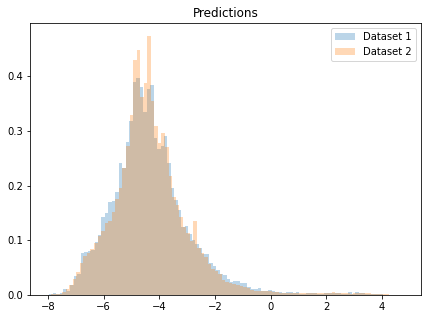

[{'mean_difference': -0.004062825373114087,
  'wasserstein': 0.05515615660936329,
  'kolmogorov_smirnov': {'statistic': 0.023532513249585274,
   'pvalue': 1.3409689189281609e-14}}]

In [33]:
# much better
drift_explainer2.plot_prediction_drift()
drift_explainer2.get_prediction_drift()

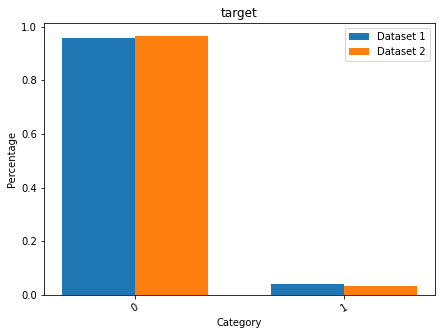

{'wasserstein': 0.008122563323150624,
 'chi2_test': {'chi2_stat': 55.39546322106872,
  'p_value': 9.856367270961643e-14,
  'dof': 1,
  'contingency_table':                 0            1
  X1   35406.404631  1579.595369
  X2  139514.000000  4998.000000}}

In [34]:
drift_explainer2.plot_target_drift()
drift_explainer2.get_target_drift()

In [35]:
# we now replicates much better what happens in production
print(f'log_loss valid: {log_loss(y_valid, clf.predict_proba(X_valid), sample_weight=sample_weights_valid_adversarial)}')
print(f'log_loss prod: {log_loss(y_prod, clf.predict_proba(X_prod))}')

print(f'AUC valid: {roc_auc_score(y_valid, clf.predict_proba(X_valid)[:, 1], sample_weight=sample_weights_valid_adversarial)}')
print(f'AUC prod: {roc_auc_score(y_prod, clf.predict_proba(X_prod)[:, 1])}')

log_loss valid: 0.12330650571420392
log_loss prod: 0.10822475472437297
AUC valid: 0.8719092733090642
AUC prod: 0.8393885465363519


## Correction on validation dataset and train dataset (in order to retrain the model)

In [36]:
drift_explainer3 = DriftExplainer()
drift_explainer3.fit(clf, X1=X_train, X2=X_prod)

In [37]:
sample_weights_train_adversarial, drift_corrector = drift_explainer3.get_adversarial_correction_weights(
    feature_subset=['D1', 'C13', 'C2', 'TransactionAmt'], return_object=True)


[0]	validation_0-error:0.31417	validation_0-auc:0.74057	validation_0-logloss:0.67586
[10]	validation_0-error:0.30043	validation_0-auc:0.76649	validation_0-logloss:0.59701
[20]	validation_0-error:0.28793	validation_0-auc:0.77703	validation_0-logloss:0.57318
[30]	validation_0-error:0.28580	validation_0-auc:0.78224	validation_0-logloss:0.56393
[40]	validation_0-error:0.28315	validation_0-auc:0.78533	validation_0-logloss:0.55911
[50]	validation_0-error:0.28160	validation_0-auc:0.78799	validation_0-logloss:0.55600
[60]	validation_0-error:0.28011	validation_0-auc:0.78979	validation_0-logloss:0.55383
[70]	validation_0-error:0.27879	validation_0-auc:0.79217	validation_0-logloss:0.55087
[80]	validation_0-error:0.27770	validation_0-auc:0.79366	validation_0-logloss:0.54903
[90]	validation_0-error:0.27625	validation_0-auc:0.79547	validation_0-logloss:0.54688
[100]	validation_0-error:0.27531	validation_0-auc:0.79673	validation_0-logloss:0.54551
[110]	validation_0-error:0.27305	validation_0-auc:0.79

[50]	validation_0-error:0.28136	validation_0-auc:0.78937	validation_0-logloss:0.55453
[60]	validation_0-error:0.27778	validation_0-auc:0.79211	validation_0-logloss:0.55128
[70]	validation_0-error:0.27591	validation_0-auc:0.79356	validation_0-logloss:0.54928
[80]	validation_0-error:0.27450	validation_0-auc:0.79515	validation_0-logloss:0.54741
[90]	validation_0-error:0.27266	validation_0-auc:0.79708	validation_0-logloss:0.54527
[100]	validation_0-error:0.27140	validation_0-auc:0.79821	validation_0-logloss:0.54395
[110]	validation_0-error:0.27084	validation_0-auc:0.79950	validation_0-logloss:0.54256
[120]	validation_0-error:0.26811	validation_0-auc:0.80184	validation_0-logloss:0.54023
[130]	validation_0-error:0.26717	validation_0-auc:0.80318	validation_0-logloss:0.53871
[140]	validation_0-error:0.26571	validation_0-auc:0.80464	validation_0-logloss:0.53719
[150]	validation_0-error:0.26495	validation_0-auc:0.80506	validation_0-logloss:0.53661
[160]	validation_0-error:0.26420	validation_0-au

In [38]:
clf2 = XGBClassifier(n_estimators=1000,
                    booster="gbtree",
                    objective="binary:logistic",
                    learning_rate=0.1,
                    max_depth=6,
                    use_label_encoder=False,
                    seed=seed)

In [39]:
# we use a gamma factor as in the book
clf2.fit(X=X_train, y=y_train, eval_set=[(X_valid, y_valid)], sample_weight=sample_weights_train_adversarial**0.3,
         early_stopping_rounds=20, verbose=10, eval_metric=['auc', 'logloss'],
         sample_weight_eval_set=[sample_weights_valid_adversarial])

[0]	validation_0-auc:0.75832	validation_0-logloss:0.61081
[10]	validation_0-auc:0.80557	validation_0-logloss:0.25246
[20]	validation_0-auc:0.82794	validation_0-logloss:0.16305
[30]	validation_0-auc:0.85213	validation_0-logloss:0.13614
[40]	validation_0-auc:0.86319	validation_0-logloss:0.12733
[50]	validation_0-auc:0.86843	validation_0-logloss:0.12480
[60]	validation_0-auc:0.87064	validation_0-logloss:0.12380
[70]	validation_0-auc:0.87161	validation_0-logloss:0.12343
[80]	validation_0-auc:0.87270	validation_0-logloss:0.12338
[90]	validation_0-auc:0.87321	validation_0-logloss:0.12306
[100]	validation_0-auc:0.87348	validation_0-logloss:0.12293
[110]	validation_0-auc:0.87470	validation_0-logloss:0.12252
[120]	validation_0-auc:0.87466	validation_0-logloss:0.12257
[130]	validation_0-auc:0.87481	validation_0-logloss:0.12245
[133]	validation_0-auc:0.87479	validation_0-logloss:0.12236


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1,
              random_state=2021, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=2021, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [40]:
print(f'log_loss valid: {log_loss(y_valid, clf2.predict_proba(X_valid), sample_weight=sample_weights_valid_adversarial)}')
print(f'log_loss prod: {log_loss(y_prod, clf2.predict_proba(X_prod))}')

print(f'AUC valid: {roc_auc_score(y_valid, clf2.predict_proba(X_valid)[:, 1], sample_weight=sample_weights_valid_adversarial)}')
print(f'AUC prod: {roc_auc_score(y_prod, clf2.predict_proba(X_prod)[:, 1])}')

log_loss valid: 0.12232601363611117
log_loss prod: 0.1089232309824619
AUC valid: 0.8753542734966466
AUC prod: 0.841585674509493
